In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import math

In [99]:
# Epoch means passing over the whole training dataset once
# one epoch is 7 mini-batches for B=500
# Implement linear regression and SGD

dimension         = 28 * 28  # Size of the image

wd_coef           = 0       # weight decay coefficient
learningRate      = 0.005
numIteration      = 20000   # iteration is an SGD update through the entire pass of one mini-batch
numTrainingSet    = 3500
batchSize         = 500     # size of mini-batch, size of data going into GradientDescentOptimizer

# Load the Data
with np.load("notMNIST.npz") as data:
    Data, Target = data["images"], data["labels"]
    posClass = 2
    negClass = 9
    dataIndx = (Target==posClass) + (Target==negClass)
    Data = Data[dataIndx]/255.
    Target = Target[dataIndx].reshape(-1, 1)
    Target[Target==posClass] = 1
    Target[Target==negClass] = 0
    
    np.random.seed(521)
    randIndx = np.arange(len(Data))
    np.random.shuffle(randIndx)
    
    Data, Target = Data[randIndx], Target[randIndx]
    Data = Data.reshape(-1, dimension)
    trainData, trainTarget = Data[:3500], Target[:3500]
    validData, validTarget = Data[3500:3600], Target[3500:3600]
    testData, testTarget = Data[3600:], Target[3600:]


In [100]:
# Variable creation
W = tf.Variable(tf.truncated_normal(shape=[dimension,1], stddev=0.5, name='weights'))
b = tf.Variable(0.0, name='bias')
X = tf.placeholder(tf.float32, [None, dimension], name='input_x')
y_target = tf.placeholder(tf.float32, [None, 1], name='target_y')

In [101]:
def buildGraph(wdCoef, learningRate):
    # Graph definition
    y_predicted = tf.matmul(X, W) + b

    # Error definition
    MSELoss = tf.reduce_mean(tf.reduce_sum(tf.square(y_predicted - y_target), 
                                                   reduction_indices=1, 
                                                   name='mean_squared_error'),
                                     name='mean_square_error')
    WDLoss = wdCoef * tf.reduce_sum(tf.square(W))
    totalLoss = (MSELoss + WDLoss)/2
    
    # Training mechanism
    optimizer = tf.train.GradientDescentOptimizer(learning_rate = learningRate)
    train = optimizer.minimize(loss=totalLoss)
    
    return y_predicted, MSELoss, WDLoss, totalLoss, train


In [102]:
def runFullIteration(weightDecayCoef, learningRate, batchSize):
    numBatches        = int(numTrainingSet/batchSize)
    numEpoch          = int(math.ceil(numIteration/numBatches))
    
    y_predicted, MSELoss, WDLoss, totalLoss, train = buildGraph(weightDecayCoef, learningRate)
    
    # Initialize session    
    init = tf.global_variables_initializer()
    sess = tf.InteractiveSession()
    sess.run(init)

    # Train for numIteration amount
    iteration = 0
    lossMSEList = []
    lossTotalList = []
    for epochIdx in range(numEpoch):
        # Randomly permute the order of training examples
        randIdx = np.arange(numTrainingSet)
        np.random.shuffle(randIdx)

        # Mini-batching over entire dataset
        lossMSE, lossTotal = 0, 0
        
        for batchIdx in range(numBatches):
            ridx_start = batchIdx * batchSize
            ridx_end = int(batchIdx+1) * batchSize

            _, lossMSE, lossTotal, currentW, currentb, yhat = sess.run([train, MSELoss, totalLoss, W, b, y_predicted],
                                                        feed_dict={X: trainData[randIdx[ridx_start:ridx_end],:],
                                                                   y_target: trainTarget[randIdx[ridx_start:ridx_end]]
                                                                  }
                                                       )
        
        lossMSEList.append(lossMSE)
        lossTotalList.append(lossTotal)
    
    return lossTotalList, lossMSEList, totalLoss, sess, y_predicted

In [8]:
import time

def runFullIterationTimed(weightDecayCoef, learningRate, batchSize):
    numBatches        = int(numTrainingSet/batchSize)
    numEpoch          = int(math.ceil(numIteration/numBatches))
    
    y_predicted, MSELoss, WDLoss, totalLoss, train = buildGraph(weightDecayCoef, learningRate)
    
    # Initialize session    
    init = tf.global_variables_initializer()
    sess = tf.InteractiveSession()
    sess.run(init)

    # Train for numIteration amount
    iteration = 0
    lossMSEList = []
    lossTotalList = []
    timeList = []
    printed = False
    startTime = time.time()
    for epochIdx in range(numEpoch):
        # Randomly permute the order of training examples
        randIdx = np.arange(numTrainingSet)
        np.random.shuffle(randIdx)

        # Mini-batching over entire dataset
        lossMSE, lossTotal = 0, 0
        
        for batchIdx in range(numBatches):
            ridx_start = batchIdx * batchSize
            ridx_end = int(batchIdx+1) * batchSize

            _, lossMSE, lossTotal, currentW, currentb, yhat = sess.run([train, MSELoss, totalLoss, W, b, y_predicted],
                                                        feed_dict={X: trainData[randIdx[ridx_start:ridx_end],:],
                                                                   y_target: trainTarget[randIdx[ridx_start:ridx_end]]
                                                                  }
                                                       )
        
            lossMSEList.append(lossMSE)
            lossTotalList.append(lossTotal)
            timeList.append(time.time() - startTime)
    
    return lossTotalList, lossMSEList, totalLoss, sess, timeList

1.1 Tuning the learning rate
======
Write a Tensorflow script that implements linear regression and the stochastic gradient descent algorithm with mini-batch size B = 500. Train the linear regression model on the
two-class notMNIST dataset by using SGD to optimize the total loss L. Set the weight
decay coefficient λ = 0 and use 20000 iterations (one iteration is an SGD update through
the entire pass of one mini-batch). Plot the training loss function vs number of epochs for
learning rate η = f0:005; 0:001; 0:0001g on the same plot (epoch means passing over the
whole training dataset once, i.e., one epoch = 7 mini-batches for B = 500). Choose the best
learning rate found and discuss the effect of the learning rate value on training convergence

In [18]:
# 1. Tuning the learning rate
wd_coef           = 0       # weight decay coefficient
learningRateList  = (0.005, 0.001, 0.0001)

numIteration      = 20000   # iteration is an SGD update through the entire pass of one mini-batch
numTrainingSet    = 3500
batchSize         = 500     # size of mini-batch, size of data going into GradientDescentOptimizer

resultList1 = []

In [19]:
for rate in learningRateList:
    totalLossList, _, _, _, _= runFullIteration(wd_coef, rate, batchSize)
    resultList1.append(totalLossList)
    print("Done", rate)

Done 0.005
Done 0.001
Done 0.0001


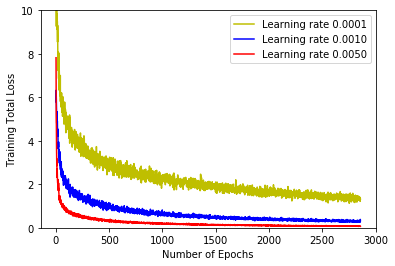

In [20]:
fig = plt.figure()
xRange = np.arange(1, len(resultList1[0])+1)

plt.plot(xRange, resultList1[2], 'y-', label='Learning rate %.4f' % (learningRateList[2]))
plt.plot(xRange, resultList1[1], 'b-', label='Learning rate %.4f' % (learningRateList[1]))
plt.plot(xRange, resultList1[0], 'r-', label='Learning rate %.4f' % (learningRateList[0]))
plt.ylim((0, 10)) 
plt.xlabel('Number of Epochs')
plt.ylabel('Training Total Loss')
plt.legend()
plt.show()

1.2 Effect of the mini-batch size
=====
Run the SGD algorithm with B = f500; 1500; 3500g with the learning rate chosen from point
1, λ = 0, and 20000 iterations. Report the final training MSE for each mini-batch value.
What is the best mini-batch size in terms of training time? Comment on your observation.

In [9]:
wd_coef           = 0       # weight decay coefficient
learningRate      = 0.005

numIteration      = 20000   # iteration is an SGD update through the entire pass of one mini-batch
numTrainingSet    = 3500
batchSizeList     = (500, 1500, 3500)     # size of mini-batch, size of data going into GradientDescentOptimizer

resultList2 = []
resultList2_time = []

In [10]:
for batchSize in batchSizeList:
    _ , lossMSEList, _, _,timeList = runFullIterationTimed(wd_coef, learningRate, batchSize)
    resultList2.append(lossMSEList)
    resultList2_time.append(timeList)
    print("Done", batchSize)

Done 500
Done 1500
Done 3500


 500 batch size has final training MSE of 0.164107
1500 batch size has final training MSE of 0.148685
3500 batch size has final training MSE of 0.132362


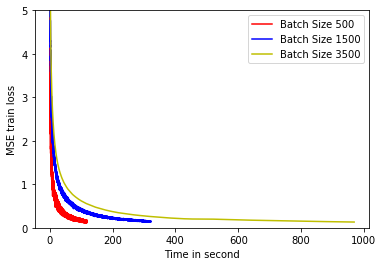

Note we have used CPU: Intel i5-5300U, Memory 8GB


In [22]:
for i in range(len(batchSizeList)):
    print("%4d batch size has final training MSE of %f" % (batchSizeList[i], resultList2[i][-1]))

fig = plt.figure()

xRangeList = []
for i in range(len(batchSizeList)):
    xRangeList.append(range(len(resultList2[i])))
    
plt.plot(resultList2_time[0], resultList2[0], 'r-', label='Batch Size %d' % (batchSizeList[0]))
plt.plot(resultList2_time[1], resultList2[1], 'b-', label='Batch Size %d' % (batchSizeList[1]))
plt.plot(resultList2_time[2], resultList2[2], 'y-', label='Batch Size %d' % (batchSizeList[2]))
plt.ylim((0, 5)) 
plt.xlabel('Time in second')
plt.ylabel('MSE train loss')
plt.legend()
plt.show()

print ("Note we have used CPU: Intel i5-5300U, Memory 8GB")

1.3 Generalization
====
Run SGD with mini-batch size B = 500, learning rate η = 0:005, and 20000 iterations to
choose the best weight decay coefficient that gives the best classification accuracy on the
validation set from λ = f0:; 0:001; 0:1; 1g. Report the validation set accuracy for different
values of λ. Report the best λ based on the validation accuracy, what is the test accuracy
for this λ? Comment on the effect of weight-decay regularization on the model performance.
Also, comment on why we need to tune the hyper-parameter λ using a validation set instead
of the training set.

In [103]:
# validation set accuracy
wd_coef_list      = [0., 0.001, 0.1, 1.]
learningRate      = 0.005

numIteration      = 20000   # iteration is an SGD update through the entire pass of one mini-batch
numTrainingSet    = 3500
batchSize         = 500

# Total loss on training set
resultList3 = []

# Total loss on validation and testing
validLossList = []
testLossList = []

# Predicted values on validation and testing
validPredList = []
testPredList = []

In [104]:
for wd_coef in wd_coef_list:
    lossTotalList, finalMSELoss, totalLossHandle, sess, y_pred_h = runFullIteration(wd_coef, learningRate, batchSize)
    validResult, validPred = sess.run([totalLossHandle, y_pred_h], feed_dict={X: validData, y_target: validTarget})
    testResult, testPred = sess.run([totalLossHandle, y_pred_h], feed_dict={X: testData, y_target: testTarget})

    # Total loss on training set
    resultList3.append(lossTotalList)

    # Total loss on validation and testing
    validLossList.append(validResult)
    testLossList.append(testResult)
    
    # Predicted values on validation and testing
    validPredList.append(validPred)
    testPredList.append(testPred)
    
    print("Done", wd_coef)

Done 0.0
Done 0.001
Done 0.1
Done 1.0


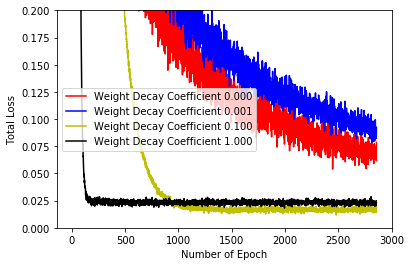

0.0000 Weight Decay Coefficient, validation total loss: 0.096419, test total loss: 0.125413
0.0010 Weight Decay Coefficient, validation total loss: 0.162092, test total loss: 0.107375
0.1000 Weight Decay Coefficient, validation total loss: 0.017119, test total loss: 0.018610
1.0000 Weight Decay Coefficient, validation total loss: 0.023110, test total loss: 0.022365


In [105]:
fig = plt.figure()
xRange = np.arange(1, len(resultList3[0])+1)
plt.plot(xRange, resultList3[0], 'r-', label='Weight Decay Coefficient %.3f' % (wd_coef_list[0]))
plt.plot(xRange, resultList3[1], 'b-', label='Weight Decay Coefficient %.3f' % (wd_coef_list[1]))
plt.plot(xRange, resultList3[2], 'y-', label='Weight Decay Coefficient %.3f' % (wd_coef_list[2]))
plt.plot(xRange, resultList3[3], 'k-', label='Weight Decay Coefficient %.3f' % (wd_coef_list[3]))

plt.xlabel('Number of Epoch')
plt.ylabel('Total Loss')
plt.ylim((0, 0.2)) 
plt.legend()
plt.show()

fig = plt.figure()

for idx in range(len(wd_coef_list)):
    print("%.4f Weight Decay Coefficient, validation total loss: %f, test total loss: %f" % (wd_coef_list[idx], validLossList[idx], testLossList[idx]))


In [107]:
# Report the validation set accuracy for different values of lambda
# Report the best lambda based on the validation accuracy
# What is the test accuracy on this lambda

def classifyList(predList):
    classList = []
    for flt in predList:
        if (flt < 0.5):
            classList.append(0)
        else:
            classList.append(1)
    return classList

def calculateAccuracy(list1, list2):
    numCorrect = 0
    assert (len(list1) == len(list2))
    
    for idx in range(len(list1)):
        if (list1[idx] == list2[idx]):
            numCorrect += 1
        
    return (numCorrect/len(list1))

validTargetList = validTarget.reshape(-1)
testTargetList = testTarget.reshape(-1)

for idx in range(len(wd_coef_list)):    
    print("%.4f Weight Decay Coefficient, validation accuracy: %f, test accuracy: %f" 
          % (wd_coef_list[idx],
             calculateAccuracy(validTargetList, classifyList(validPredList[idx])), 
             calculateAccuracy(testTargetList, classifyList(testPredList[idx]))))

0.0000 Weight Decay Coefficient, validation accuracy: 0.870000, test accuracy: 0.882759
0.0010 Weight Decay Coefficient, validation accuracy: 0.870000, test accuracy: 0.910345
0.1000 Weight Decay Coefficient, validation accuracy: 0.980000, test accuracy: 0.972414
1.0000 Weight Decay Coefficient, validation accuracy: 0.970000, test accuracy: 0.965517


In [ ]:
# Comment on the effect of weight-decay regularization on the model performance. 
# Also, comment on why we need to tune the hyper-parameter λ using a validation set instead of the training set.

1.4 Comparing SGD with normal equation
===
For linear regression, you can find the optimum weights using the closed form equation for
the derivative of the means square error (normal equation). For zero weight decay, Write a
TensorFlow script to find the optimal linear regression weights on the two-class notMNIST
dataset using the \normal equation" of the least squares formula. Compare in terms of final
training MSE, accuracy and computation time between SGD and normal equation. Also,
discuss when SGD is more practical than using normal equation

In [159]:
# Compare final training MSE, accuracy, computation time of SGD vs. normal equation
# Discuss when SGD is more practical than using normal equation

# Find W
def calculateLeastSquareW():
    sess4 = tf.Session()
    X_hat = np.insert(trainData, 0, 1, axis=1)
    XTX_inv = tf.matrix_inverse((tf.matmul(X_hat, X_hat, transpose_a=True)))
    XTX_inv_XT = tf.matmul(XTX_inv, X_hat, transpose_b=True)
    W_ls = tf.matmul(XTX_inv_XT, tf.cast(trainTarget, tf.float64))
    return sess4.run(W_ls)

def buildGraphLeastSquare():
    W = tf.placeholder(tf.float32, [dimension+1, 1], name='weights_ls')
    X = tf.placeholder(tf.float32, [None, dimension+1], name='input_x')
    y_target = tf.placeholder(tf.float32, [None, 1], name='target_y')
    
    # Graph definition
    y_predicted = tf.matmul(X, W)
    
    # Error definition
    MSELoss = tf.reduce_mean(tf.reduce_sum(tf.square(y_predicted - y_target), 
                                                   reduction_indices=1, 
                                                   name='mean_squared_error'),
                                     name='mean_square_error')

    return W, X, y_target, y_predicted, MSELoss


In [160]:
def evaluateLeastSquare():
    sess5 = tf.Session()

    calculatedW = calculateLeastSquareW()
    W, X, y_target, y_predicted, MSELoss = buildGraphLeastSquare()

    finalTrainMSELoss = sess5.run(MSELoss, feed_dict={W:calculatedW, 
                                                      X:np.insert(trainData, 0, 1, axis=1),
                                                      y_target:trainTarget})

    predictedValidY = sess5.run(y_predicted, feed_dict={W:calculatedW, 
                                                        X:np.insert(validData, 0, 1, axis=1),
                                                        y_target:trainTarget})


    predictedTestY = sess5.run(y_predicted, feed_dict={W:calculatedW, 
                                                       X:np.insert(testData, 0, 1, axis=1),
                                                       y_target:trainTarget})

    
    return finalTrainMSELoss, predictedValidY, predictedTestY
#     finalTrainMSELoss = sess4.run(MSELoss, feed_dict={W:W_ls_calculated, X:X_hat, y_target:trainTarget})
#     validLoss = sess4.run(MSELoss, feed_dict={W:W_ls_calculated, X:np.insert(validData, 0, 1, axis=1), y_target:validTarget})
#     testLoss = sess4.run(MSELoss, feed_dict={W:W_ls_calculated, X:np.insert(testData, 0, 1, axis=1), y_target:testTarget})

finalTrainMSELoss, predictedValidY, predictedTestY = evaluateLeastSquare()

In [162]:
print("Least Square Final Training MSE loss is %.4f" %(finalTrainMSELoss))

validTargetList = validTarget.reshape(-1)
testTargetList = testTarget.reshape(-1)

print("Least Square, validation accuracy: %f, test accuracy: %f" 
          % (calculateAccuracy(validTargetList, classifyList(predictedValidY)), 
             calculateAccuracy(testTargetList, classifyList(predictedTestY))))

Least Square Final Training MSE loss is 0.0188
Least Square, validation accuracy: 0.970000, test accuracy: 0.958621
